In [36]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time
import pyfeltor.dg as dg

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [37]:
data = simplesim.Manager( directory="./resistivity-new-data", filetype="nc")
diag = simplesim.Manager( directory="./resistivity-new-diag", filetype="nc")

In [38]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [39]:
# This cell may take a minute ...
print( "content")
content = data.table()
content = sorted(content, key=lambda pp: (pp['grid']['n'], pp['physical']['tau']),reverse=True)
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( data, pp)
    pp['file'] = file
print( "content")
contentdiag = diag.table()
contentdiag = sorted(contentdiag, key=lambda pp: (pp['grid']['n'], pp['physical']['tau']),reverse=True)
for pp in contentdiag : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'],pp['grid']['n'],pp['output']['compression'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file


content
0.0001 1.0 3 [2, 2]
0.0001 0.0 3 [2, 2]
content
0.0001 1.0 3 [2, 2]
0.0001 0.0 3 [2, 2]


In [40]:
da0 = Dataset( data.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content+contentdiag : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['dvdpsi'] = da0['dvdpsi'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])# lcfs index
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]
    

0.0001 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters
0.0001 1.0
Invert for given numerical parameters
0.0001 0.0
Invert for given numerical parameters


In [41]:
min_idx_dict = {
    0 : {1e-6: 1, 1e-4 : 1 , 1e-5 : 1, 3e-6: 1, 3e-5 : 1, 3e-4: 1},
    1 : {1e-6: 1, 1e-4 : 1 , 1e-5 : 1, 3e-6: 1, 3e-5 : 1, 3e-4: 1}          
} # in cs/R0

In [42]:
# http://vrl.cs.brown.edu/color
colors =[ 
# "#256676", "#b4dbe7", "#1e39ae", "#aad46f", "#940393",
#  "#43e26d", "#d60724", "#3eeaef", "#0b5313", "#cd6ad8" #change color 6,which is red
# "#32964d", "#ad0599", "#39f27a", "#323d96", "#2fddce",
#  "#0a4f4e", "#a1d832", "#8b6fed", "#38b5fc", "#752e4f"
'C0','C1','C2','C4','C5','C6','C7','C8','C9'    
]

### Some thoughts on why Div formulation of FSAs may be better than currents

We should understand that
\begin{align}
F(\psi_p) := \langle f\rangle
\end{align}
is computed by evaluating a (numerically computed) function on a one-dimensional dG grid (the $\psi_p$ grid).
It is likely that the individual elements $F_i$ have errors $F_i\pm \varepsilon_i$. Maybe Computing derivatives 
\begin{align}
 \frac{\partial F}{\partial v}
 \end{align}
is difficult because we do not know in which dG derivative $F$ converged, so a dG derivative may introduce oscillations. Also evaluating $F$ at the LCFS (or on any cell boundary in general) is problematic because dG is not ambiguous on boundaries; probably using dG also has an extrapolation error and very much depends on the errors in the last cell.
(If this was true it would be necessary to compute 
\begin{align}
 \langle \vec j \cdot \nabla v\rangle|_{LCFS}
\end{align}
directly on the LCFS without using an extrapolation formula)



Computing integrals 
\begin{align}
\int dv \langle f\rangle 
\end{align}
is likely more precise because in our framework since this becomes Gauss-Legendre integration especially if we integrate up to a cell boundary and in particular the LCFS (which is a cell-boundary). Since the flux-surface average itself is computed via
\begin{align}
F(\psi_p) = (d v/ d \psi_p)^{-1} \int d \eta  \sqrt{G} f(\zeta,\eta)
\end{align}
the volume integral is equivalent to computing directly in the $\zeta$, $\eta$ grid
\begin{align}
\int dv F = \int d \zeta d\eta \sqrt{G} f(\zeta,\eta)
\end{align}
i.e. the only error is in the interpolation from $f(R,Z)$ to $f(\zeta,\eta)$.


In [43]:
# print(len( content[0]['file'])/3)
# content[0]['file']['TEST_fsa'] = content[0]["file"]['psi_fsa']
# for item in content[0]['file']:
#     if '_fsa' in item :
#         print(item)

In [44]:
# fsa_params = content[0]["output"]["fsa"]
# psi = content[0]["file"]["psi"]
# # THIS TAKES A LONG TIME, PROBABLY FASTER TO DO IT INPLACE WHEN NEEDED
# grid = dg.create.grid_from_abscissas( [psi])
# for item in content[0]['file']:
#     if '_fsa' in item :
#         print(item)
#         ifs = item.replace('_fsa', '_ifs')
#         if ifs not in content[0]['file']:
#             content[0]['file'][ifs] = content[0]['file'][item]
#             for i in range(0,content[0]['file'][item].shape[0]):
#                 content[0]['file'][ifs] = dg.integrate(
#                     (content[0]['file'][item][:,:]*content[0]['dvdpsi'][None,:]).to_numpy(),grid)
#             print(ifs)
        

In [11]:
print( (pp['lcfs']+1)/3)

56.0


In [45]:
# This works reasonably fast

for pp in content:
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    weights = dg.create.weights( grid)*pp['dvdpsi'][:]
    lcfs_idx = pp["lcfs"]
    for item in pp['file']:
        if '_fsa' in item :
            ifs_lcfs = item.replace('_fsa', '_ifs_lcfs')
#             if ifs_lcfs not in pp['file']:
            pp['file'][ifs_lcfs] = np.sum(
                pp['file'][item][:,:lcfs_idx+1]*weights[None,:lcfs_idx+1], axis=1)


0.0001 1.0
0.0001 0.0


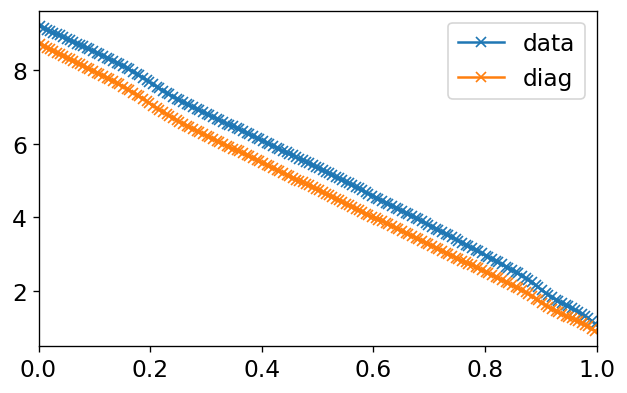

600.0


In [47]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
ax.plot( content[0]["rho"][0:168], 600*content[0]['file']["electrons_fsa"][-1,0:168]/content[0]["dvdpsi"][0:168]
        , marker = 'x', label='data')
ax.plot( contentdiag[0]["rho"][0:168], contentdiag[0]['file']["electrons_fsa"][-1,0:168]
        , marker = 'x', label='diag')
plt.xlim([0.,1])
plt.legend()
plt.savefig ("dvdpsi-orthogonal-separatrix.png",bbox_inches='tight')
plt.show()
print(9/0.015)

1.0


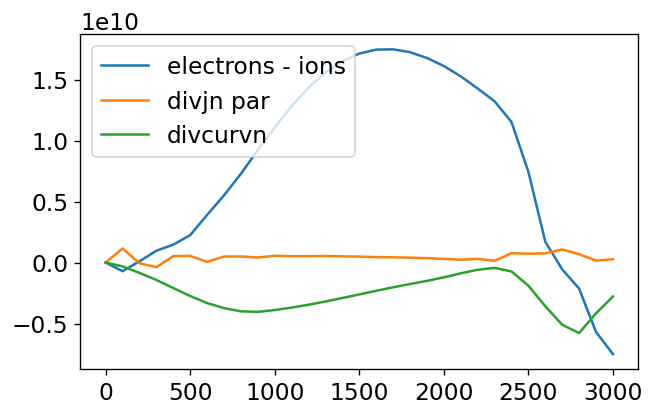

0.0


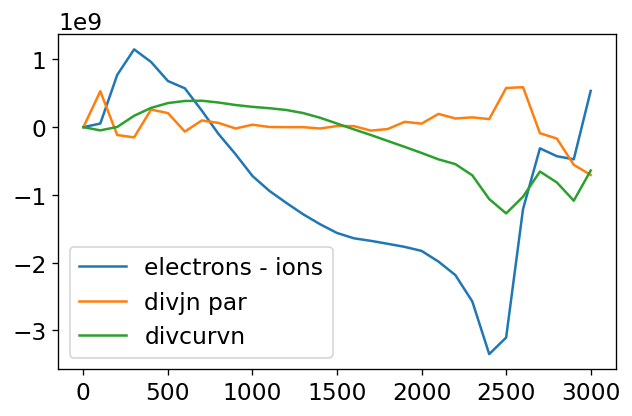

1.0


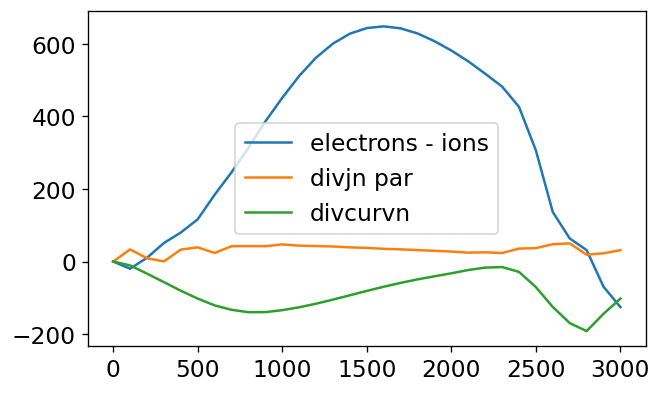

0.0


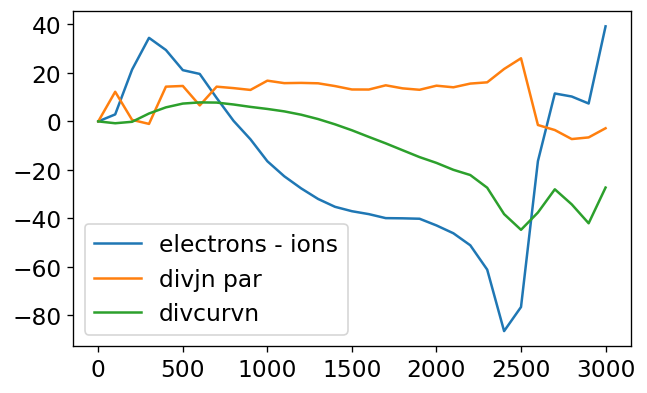

In [14]:
# Let's plot a few test
for pp in content+contentdiag:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    print( pp['physical']['tau'])
    ax.plot( pp['file']['time'], pp['file']['electrons_ifs_lcfs'][:]-pp['file']['ions_ifs_lcfs'][:],
            label='electrons - ions')
    ax.plot( pp['file']['time'], pp['file']['divjnepar_tt_ifs_lcfs'][:]-pp['file']['divjnipar_tt_ifs_lcfs'][:],
            label='divjn par')
    ax.plot( pp['file']['time'], pp['file']['divcurvne_tt_ifs_lcfs'][:]-pp['file']['divcurvni_tt_ifs_lcfs'][:],
            label='divcurvn')

    plt.legend()
    plt.show()

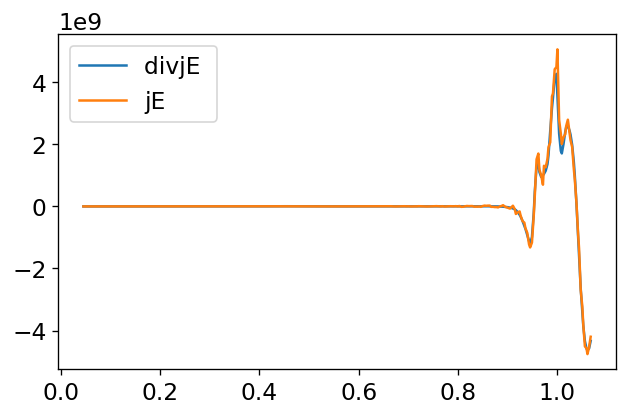

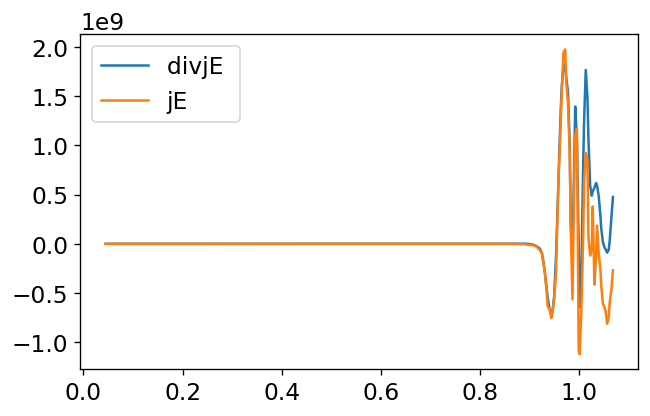

In [16]:
# Let's plot a few test
for pp in content:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
                                         -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
            label='divjE ')
    ax.plot( pp['rho_p'], (pp['file']['jsneE_tt_fsa'][-1,:]-pp['file']['jsniE_tt_fsa'][-1,:])*pp['dvdpsi'],
            label='jE ')

    plt.legend()
    plt.show()

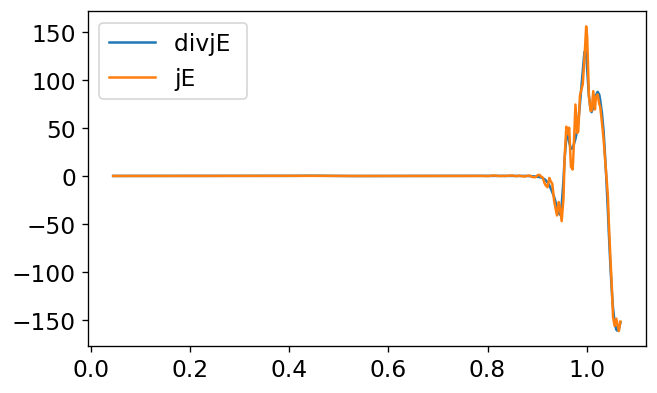

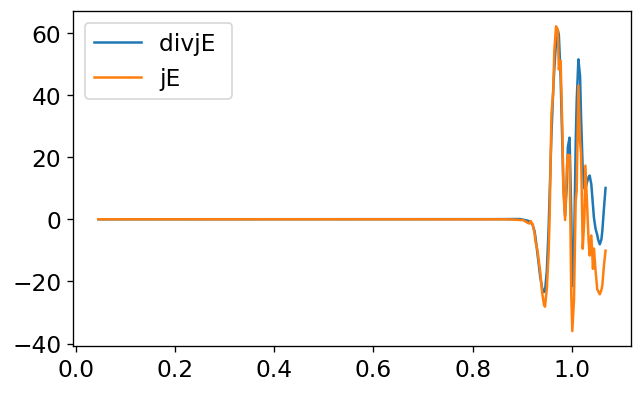

In [18]:
# Let's plot a few test
for pp in contentdiag:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divneE_tt_fsa'][-1,:]
                                         -pp['file']['divniE_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
            label='divjE ')
    ax.plot( pp['rho_p'], (pp['file']['jvneE_tt_fsa'][-1,:]-pp['file']['jvniE_tt_fsa'][-1,:]),
            label='jE ')

    plt.legend()
    plt.show()

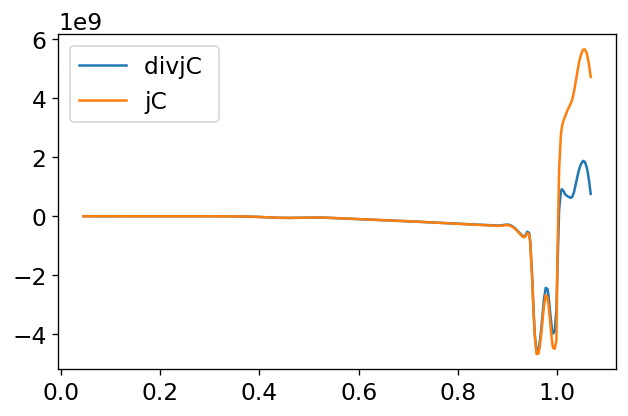

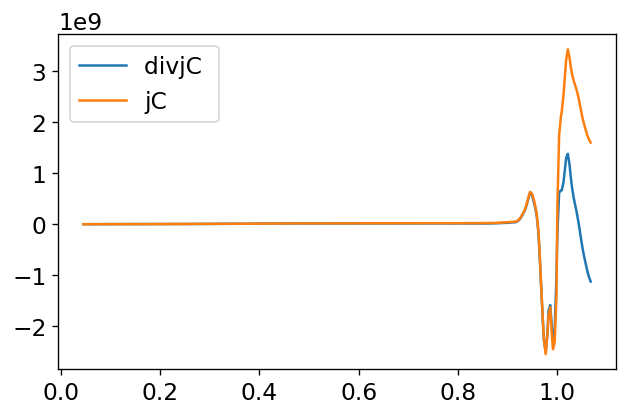

In [89]:
# Let's plot a few test
for pp in content:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    grid = dg.create.grid_from_abscissas( [pp["file"]["psi"]])
    ax.plot( pp['rho_p'], dg.integrate( ((pp['file']['divcurvne_tt_fsa'][-1,:]
                                         -pp['file']['divcurvni_tt_fsa'][-1,:])*pp['dvdpsi']).to_numpy(), grid),
            label='divjC ')
    ax.plot( pp['rho_p'], (pp['file']['jscurvne_tt_fsa'][-1,:]-
                           pp['file']['jscurvni_tt_fsa'][-1,:])*pp['dvdpsi'],
            label='jC')

    plt.legend()
    plt.show()

Depending on how exactly we compute the flux surface average we obtain different results

The problem is also the derivative of the FSA

This will generate problems when comparing quantities on the LCFS

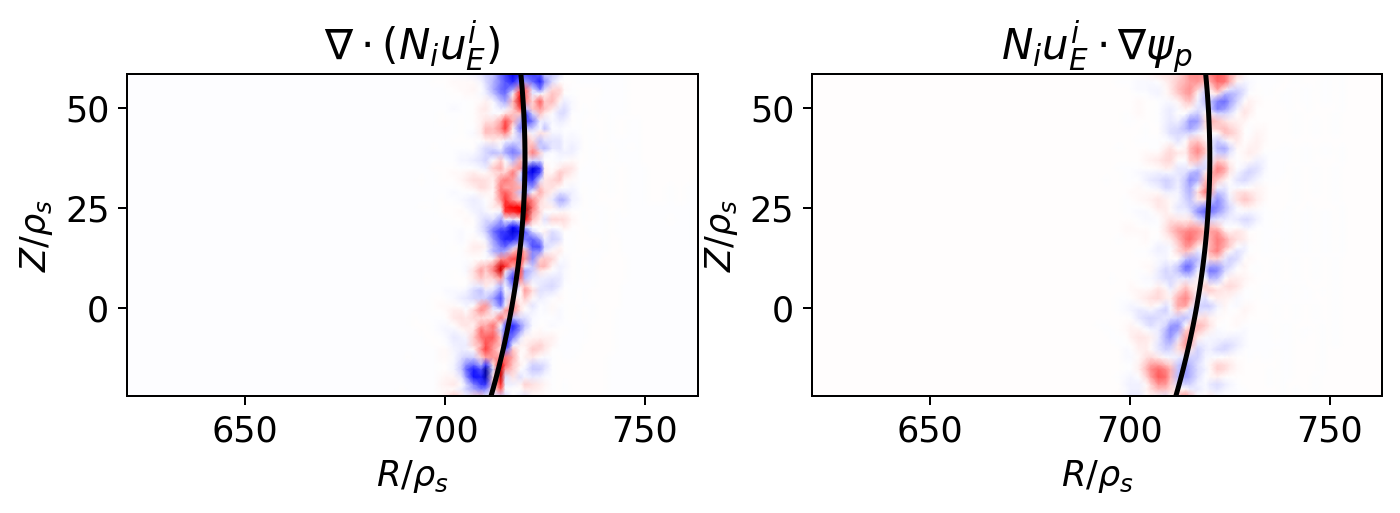

In [16]:
da = Dataset( data.outfile(data.table()[0]),'r')
fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')

# cmap=plt.get_cmap('twilight_shifted')
pcm = ax[0].pcolormesh( da['x'][200:], da['y'][250:300],
                    da['divniE_tt_2d'][-1,250:300,200:],
                       vmin=-1,vmax=1,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_xlabel( r"$R/\rho_s$")
ax[0].set_ylabel( r"$Z/\rho_s$")
ax[0].set_title( r"$\nabla \cdot( N_i u_E^i)$")
im = ax[0].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
                levels=[1], linewidths=2,colors='k')
pcm = ax[1].pcolormesh( da['x'][200:], da['y'][250:300],
                    da['jsniE_tt_2d'][-1,250:300,200:],vmin=-5,vmax=5,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlabel( r"$R/\rho_s$")
ax[1].set_ylabel( r"$Z/\rho_s$")
ax[1].set_title( r"$N_i u_E^i\cdot \nabla\psi_p$")
im = ax[1].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
                levels=[1], linewidths=2,colors='k')
# plt.savefig( 'jsni_2d.png',bbox_inches='tight')
plt.show()

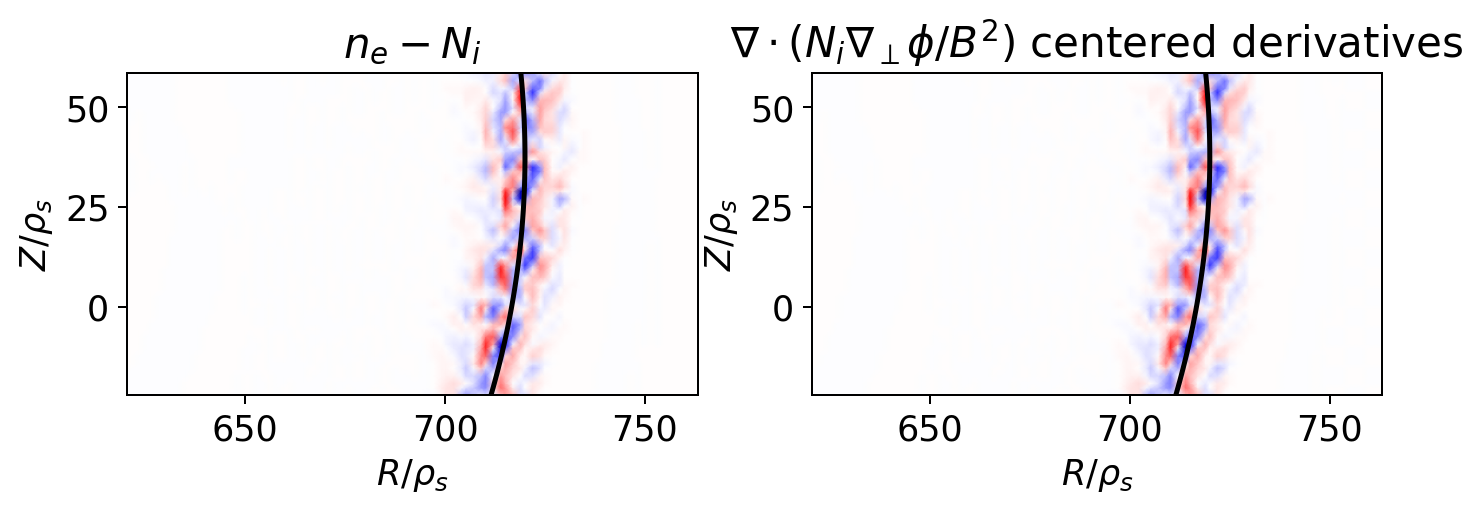

In [17]:
da = Dataset( data.outfile(data.table()[0]),'r')
fig,ax=plt.subplots(1,2,figsize=(3*3,3*3.7),dpi= 180, facecolor='w', edgecolor='k')
# cmap=plt.get_cmap('twilight_shifted')
pcm = ax[0].pcolormesh( da['x'][200:], da['y'][250:300],
                    da['electrons_2d'][-1,250:300,200:]-da['ions_2d'][-1,250:300,200:],
                       vmin=-0.3,vmax=0.3,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
im = ax[0].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
                levels=[1], linewidths=2,colors='k')
ax[0].set_aspect('equal')
ax[0].set_xlabel( r"$R/\rho_s$")
ax[0].set_ylabel( r"$Z/\rho_s$")
ax[0].set_title(r"$n_e - N_i$")
pcm = ax[1].pcolormesh( da['x'][200:], da['y'][250:300],
                    da['v_Omega_E_gf_2d'][-1,250:300,200:],vmin=-0.3,vmax=0.3,
                shading='gouraud',
                cmap="seismic",
              rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlabel( r"$R/\rho_s$")
ax[1].set_ylabel( r"$Z/\rho_s$")
ax[1].set_title(r"$\nabla\cdot ( N_i \nabla_\perp \phi/B^2)$ centered derivatives")
im = ax[1].contour( da['x'][200:], da['y'][250:300], da["Rho_p"][250:300,200:],
                levels=[1], linewidths=2,colors='k')
# plt.savefig( 'centered-derivative-elliptic-2d.png',bbox_inches='tight')
plt.show()

In [18]:
rhs = da['electrons_2d'][-1,:,:]-da['ions_2d'][-1,:,:]
error = (rhs -  da['v_Omega_E_gf_2d'][-1,:,:])
norm_error = np.sqrt(np.sum( error*da['vol2d']*error))
norm_b = np.sqrt(np.sum( rhs*da['vol2d']*rhs))
print(f"Relative error {norm_error/norm_b:0.2f}")

Relative error 0.02


In [90]:
# to_plot = dict()
# {
#     "tau" : [], # taus
#     "res": {0:[],1:[]} # resistivities for taus
#     "fields" : [ # list of dicts
#     {
#         "color": 0,
#         "label" : r"$\partial_t n_e$",
#         "vals": {0:{res: [], ...},1:{...}}, # time series for tau = 0 and tau = 1 and various resistivities
#     }
#     ]
# }
def plot_relative( to_plot, ax, tau, style):  
    """Compute mean and error of several terms described in to_plot as a function of resistivity
    on given axis ax, for given tau
    """
    resistivities = np.array(sorted(to_plot["res"][tau]))
    size = resistivities.size
    mean=dict()
    std = dict()
    
    for field in to_plot["fields"]:
        mean[field["label"]]=np.zeros(size)
        std[field["label"]]=np.zeros(size)
        for i in np.arange(0,size,1):  
            min_idx = min_idx_dict[tau][resistivities[i]]
            mean[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].mean()
            std[field["label"]][i] = field["vals"][tau][resistivities[i]][min_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = list()
    mean_error = np.zeros(size)
    std_error = np.zeros(size)
    for i in np.arange(0,size,1):   
        min_idx = min_idx_dict[tau][resistivities[i]]
        error.append(np.zeros( len(to_plot["times"][tau][resistivities[i]][min_idx:])))
        for field in to_plot["fields"]:
            error[i] = error[i] + field["vals"][tau][resistivities[i]][min_idx:]
        mean_error[i] = error[i].mean()
        std_error[i] = error[i].std()

    summe = np.abs(mean_error)
    for field in to_plot["fields"]:
        summe = summe + np.abs(mean[field["label"]])
    if style == "log":
        ax.plot( resistivities, np.abs(mean_error)/summe,
                marker='x', ls='--',label="Error",  color = "r"
               )
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, np.abs(mean[field["label"]])/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
        ax.set_yscale('log')
    elif style == 'linear':
        ax.plot( resistivities, mean_error/summe,
                marker='x', ls='--',label="Error",  color = "r"  )

        ax.fill_between(resistivities, (mean_error-std_error)/summe, (mean_error+std_error)/summe,
                        color='r', alpha=0.2)
        for field in to_plot["fields"]:
            if(mean[field["label"]].mean() != 0):
                ax.plot( resistivities, mean[field["label"]]/summe,
            #                  yerr=delta_err[tau],capsize=4
                    marker='x', ls='-',label=field["label"]
                        , color = colors[field["color"]]
                       )
                ax.fill_between(resistivities, (mean[field["label"]]-std[field["label"]])/summe,
                                (mean[field["label"]]+std[field["label"]])/summe,
                                color = colors[field["color"]],
                        alpha=0.2)
        low, high = ax.get_ylim()
        # find the new limits
        bound = max(abs(low), abs(high))
        # set new limits
        ax.set_ylim(-bound, bound)  
            
            
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel('relative importance')
    ax.set_xscale('log')    

In [91]:
def plot_series( to_plot, ax, tau, res, start_idx=1):   
    """Plot several terms described in to_plot as a function of time on given axis
    for given tau and resistivity
    """
    mean=dict()
    std = dict()
#     min_idx = min_idx_dict[tau][res]
    for field in to_plot["fields"]:
        mean[field["label"]] = field["vals"][tau][res][start_idx:].mean()
        std[field["label"]]  = field["vals"][tau][res][start_idx:].std()
#         print( "Averages ", field["label"], " is ", mean[field["label"]])
    error = np.zeros( len(to_plot["times"][tau][res]))
    for field in to_plot["fields"]:
        error = error + field["vals"][tau][res]
    mean_error = error[start_idx:].mean()
    std_error = error[start_idx:].std()
    print( "Mean error is ", mean_error, " std error is ", std_error)

    ax.plot( to_plot["times"][tau][res][start_idx:], error[start_idx:],
            ls='--',label="Error",  color = "r"
           )
    for field in to_plot["fields"]:
        ax.plot( to_plot["times"][tau][res][start_idx:], field["vals"][tau][res][start_idx:],
    #                  yerr=delta_err[tau],capsize=4
            ls='-',label=field["label"]
                , color = colors[field["color"]]
               )
#         ax.hlines(mean[field['label']], to_plot["times"][tau][res][min_idx],
#                   to_plot["times"][tau][res][-1], color=colors[field["color"]])
#         ax.fill_between( to_plot["times"][tau][res][min_idx:],
#                         (mean[field['label']]-std[field['label']]),
#                         (mean[field['label']]+std[field['label']]),
#                         color=colors[field["color"]], alpha=0.2)

    ax.hlines(mean_error, to_plot["times"][tau][res][start_idx],
              to_plot["times"][tau][res][-1], color='r')
    ax.fill_between( to_plot["times"][tau][res][start_idx:],
                    (mean_error-std_error), (mean_error+std_error),
                    color='red', alpha=0.2)
    ax.set_xlabel(r'$t$ / $\Omega_0^{-1}$')
    ax.set_ylabel(r'$\int_0^{v(1)} \langle t_i(R,Z,\varphi,t)\rangle dv$')
    # get y-axis limits of the plot
    low, high = ax.get_ylim()
    # find the new limits
    bound = max(abs(low), abs(high))
    # set new limits
    ax.set_ylim(-bound, bound)

In [92]:
def make_to_plot( to_plot, in_content):
    """Fill in values in the to_plot dictionary"""
    for pp in in_content :
        da = pp['file']
        time = np.asarray(da['time'][:])
        deltat = np.diff(np.append(time, 2*time[-1] -time[-2]))
        tau = pp["physical"]["tau"]
        res = pp["physical"]["resistivity"]
        to_plot["res"][tau].append(res)
        to_plot["times"][tau][res] = time
        to_plot["params"][tau][res] = pp 
        for field in to_plot["fields"]:
            series = np.zeros(len(time))
            for (name,sign,derive) in zip(field["names"],field["signs"],field['derive']):
                addition = np.zeros(len(time))
#                 print(field)
                if "idx" in field.keys():
                    addition = np.asarray(da[name][:,field["idx"]])*sign
                else:
                    addition = np.asarray(da[name][:])*sign
                if derive:
                    addition = np.diff(np.append(np.zeros(1),addition, axis=0))/deltat
                else:
                    addition = addition/deltat
                series = series + addition
            field["vals"][tau][res] = series

In [93]:
### THE TERMS IN THE DENSITY CONSERVATION
to_plot_mass = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
#         "names" : ["electrons_ifs_lcfs","sne_tt_ifs_lcfs","divneuE_tt_ifs_lcfs","divcurvne_tt_ifs_lcfs"],"idx":idx,
        "names" : ["ions_ifs_lcfs","sni_tt_ifs_lcfs","divniE_tt_ifs_lcfs","divcurvni_tt_ifs_lcfs"],
        "derive" : [True,False,False,False], "signs" : [+1,-1,+1,+1],
        "color": 0,
        "label" : r"$\partial_t (n_e) - S_e + j_E + j_K$",
        "vals": {0:dict(),1:dict()},
    },

    {
#         "names" : ['divneuA_tt_ifs_lcfs'], "idx":idx, "derive" : [False], "signs" : [+1],
        "names" : ['divniA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['jvneC_tt_ifs_lcfs_lcfs'], "derive" : [False], "signs" : [+1],
#         "names" : ['jvniC_tt_ifs_lcfs_lcfs'], "derive" : [False], "signs" : [+1],
#         "color": 2,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divcurvkappani_tt_ifs_lcfs' ],
#         "names" : ['divcurvkappane_tt_ifs_lcfs' ],
        "derive" : [False], "signs" : [+1],
        "color":3,
        "label" : r"$\nabla\cdot\vec{ j_{kappa}}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['divcurvne_tt_ifs_lcfs' ],
# #         "names" : ['divcurvni_tt_ifs_lcfs' ],
#         "derive" : [False], "signs" : [+1],
#         "color":4,
#         "label" : r"$\nabla\cdot\vec{ j_{curv}}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
#         "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "names" : ['divjnipar_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    { 
#         "names" : ['lneperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "names" : ['lniperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 6,
        "label" : r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "names" : ['lniparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 7,
        "label" : r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}



Mean error is  -1495366.6163127164  std error is  2326256.698750952


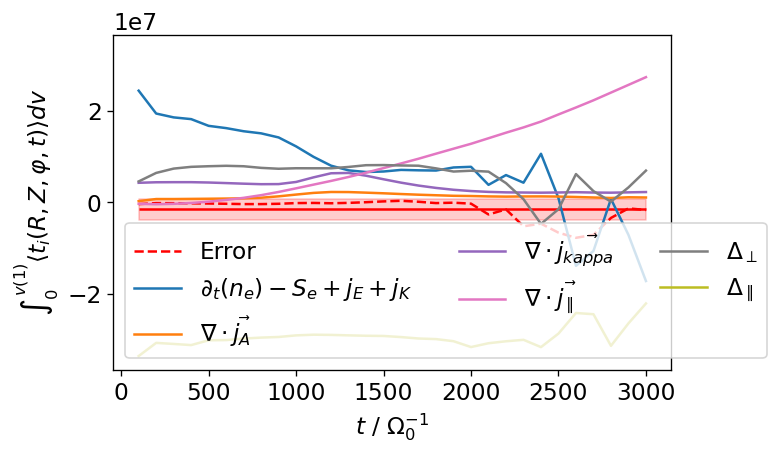

Mean error is  -1728521.312172902  std error is  3003286.357144316


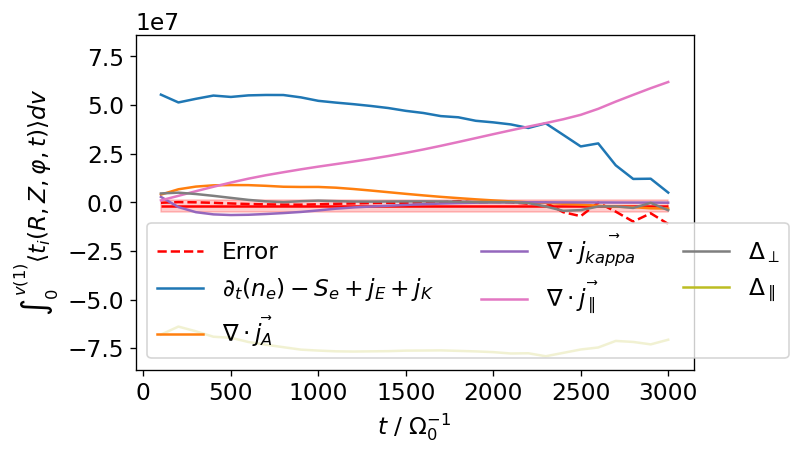

In [94]:
# content_nn = [content2[1],content2[2]]
content_nn = [content[0],content[1]]
# print( content[2]["output"]["compression"], content[2]["physical"]["tau"])
make_to_plot(to_plot_mass,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_mass,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
# plt.ylim([-100000, 100000])
plt.show()
# print( content[3]["output"]["compression"], content[3]["physical"]["tau"])

# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_mass,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
# plt.ylim([-100000, 100000])
plt.show()

In [97]:
### THE TERMS IN THE VORTICITY/DENSITY DIFF CONSERVATION
to_plot_mass_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs","ions_ifs_lcfs"], "derive" : [True,True], "signs" : [+1,-1],
#         "names" : ["ions_ifs_lcfs"], "derive" : [True], "signs" : [-1],
        "color": 0,
        "label" : r"$\partial_t (n_e-N_i)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "names" : ['divneE_tt_ifs_lcfs','divniE_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 6,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "names" : ['divneA_tt_ifs_lcfs','divniA_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 8,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['jvneC_tt_ifs_lcfs','jvniC_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
#         "color": 2,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs'],
#         "derive" : False, "signs" : [+1,-1],
#         "color":6,
#         "label" : r"$\nabla\cdot\vec{ j_k}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divcurvkappane_tt_ifs_lcfs','divcurvkappani_tt_ifs_lcfs',
                   'divcurvne_tt_ifs_lcfs','divcurvni_tt_ifs_lcfs' ],
        "derive" : [False,False,False,False], "signs" : [+1,-1,+1,-1],
        "color":2,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['v_J_D_gf_tt_ifs_lcfs' ],
#         "derive" : False, "signs" : [-1],
#         "color":8,
#         "label" : r"$\nabla\cdot\vec{ j_C}$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divjnepar_tt_ifs_lcfs','divjnipar_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [+1,-1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
#     { # 1e-6 for both 
#         "names" : ['sne_tt_ifs_lcfs','sni_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
#         "color": 4,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
    { # lniperp has a mistake
        "names" : ['lneperp_tt_ifs_lcfs','lniperp_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
#         "names" : ['loexbe_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 5,
        "label" : r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs','lniparallel_tt_ifs_lcfs'], "derive" : [False,False], "signs" : [-1,+1],
        "color": 7,
        "label" : r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}



Mean error is  49673.477820721826  std error is  1915675.490186756


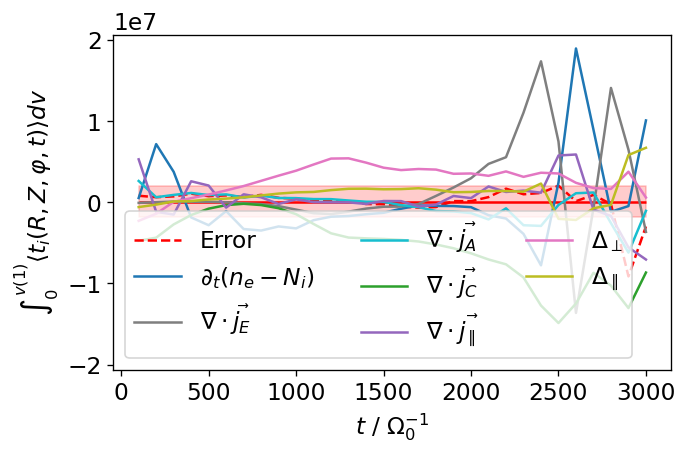

Mean error is  171713.6819345198  std error is  4200326.858430105


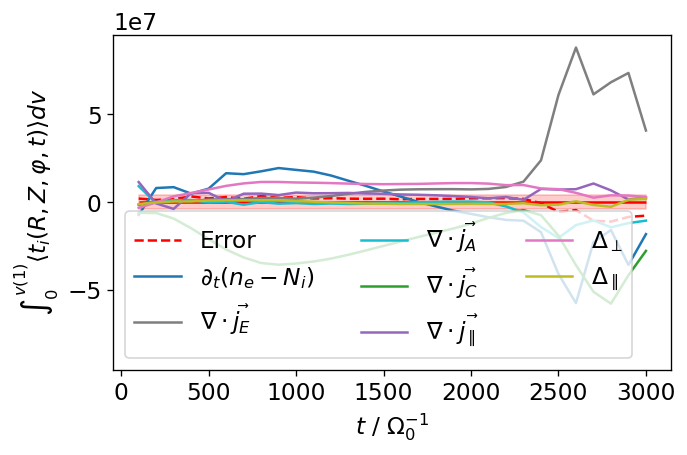

In [98]:
content_nn = [content[1],content[0]]
make_to_plot(to_plot_mass_diff,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_mass_diff,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()
# print( content[3]["output"]["compression"], content[3]["physical"]["tau"])

# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_mass_diff,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
# plt.ylim([-100000, 100000])
plt.show()

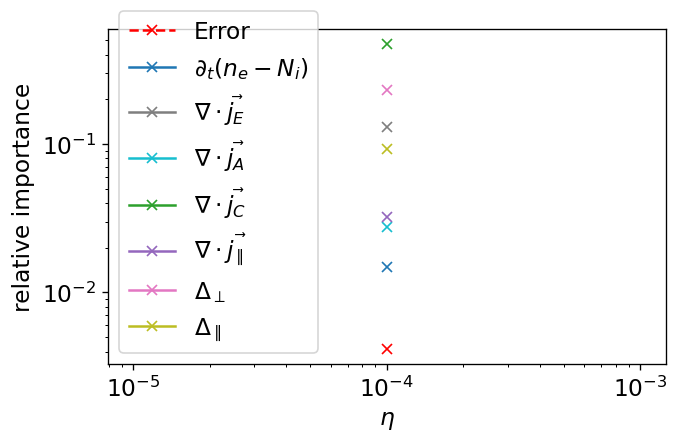

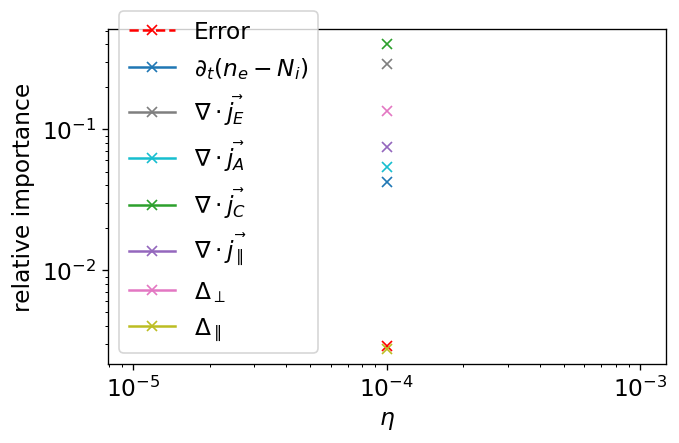

In [99]:
# content_nn = [content[2]]
# make_to_plot(to_plot_mass_diff,content_nn)
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=1,loc='lower left')
#     plt.ylim([1e-4,1])
#     plt.savefig( 'neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
#     plt.show()
# content_nn = [content[1]]
# make_to_plot(to_plot_mass_diff,content_nn)
# # more diffusion needed for tau=1 simulations?
# # n_e - N_i not relevant for tau = 1 simulations?
# for tau in [1]:
# #     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     plot_relative(to_plot_mass_diff,ax,tau,'log')
# #     ax.set_yscale("linear")
# #     plt.legend(ncol=3,loc='lower right')
# #     plt.ylim([1e-6,1])
# #     plt.savefig( 'neni-diff-importance-'+str(tau)+'.png',bbox_inches='tight')
#     plt.show()  

In [100]:
### THE TERMS IN THE COCE CONSERVATION
to_plot_coce = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["v_Omega_E_gf_ifs_lcfs", "v_Omega_D_gf_ifs_lcfs"], "derive" : [True], "signs" : [+1,+1],
        "color": 0,
        "label" : r"$\partial_t (\Omega)$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_E_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{ j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneE_tt_ifs_lcfs','jvniE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_adv_D_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_D}$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvneA_tt_ifs_lcfs','jvniA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1,-1],
        "names" : ['v_M_em_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 3,
        "label" : r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_mag_gf_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 4,
        "label" : r"$\nabla\cdot\vec{ j_{mag}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_bperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{ j_{\perp}}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_D_gf_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color":6,
        "label" : r"$\nabla\cdot\vec{ j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['v_J_par_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 7,
        "label" : r"$\nabla\cdot\vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },

    ]
}

In [101]:
content_nn = [content[2],content[5]]
print( content_nn[0]["output"]["compression"])
make_to_plot(to_plot_coce,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 0
res = 1e-4
plot_series(to_plot_coce,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()
# content_nn = [content[1]]
print( content_nn[0]["output"]["compression"])
make_to_plot(to_plot_coce,content_nn)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_coce,ax,tau,res)

plt.legend(ncol=3,loc='lower left')
plt.show()

IndexError: list index out of range

In [ ]:
content_nn = [content3[0]]
make_to_plot(to_plot_coce,content_nn)
# more diffusion needed for tau=1 simulations?
# n_e - N_i not relevant for tau = 1 simulations?
for tau in [1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_mass_diff,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=1,loc='lower left')


In [219]:
### THE TERMS IN THE MASS CONSERVATION
to_plot = {
    "tau" : [1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["electrons_ifs_lcfs"], "derive" : [True], "signs" : [+1],
#         "names" : ["ions_ifs_lcfs"], "derive" : True, "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t n_e$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divneE_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "names" : ['jvniE_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divcurvne_tt_ifs_lcfs','divcurvkappane_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
#         "names" : ['jvniC_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{j_C}$",
        "vals": {0:dict(),1:dict()},
    },
    {# small here but not in vorticity 
        "names" : ['divneA_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
#         "names" : ['jvniA_tt_ifs_lcfs'], "derive" : False, "signs" : [+1],
        "color": 3,
        "label" :  r"$\nabla\cdot\vec{ j_A}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divjnepar_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 4,
        "label" :  r"$\nabla \cdot \vec{ j_\parallel}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "names" : ['lniperp_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        # lniperp has a mistake in the feltordiag
        "color": 5,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['lneparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sne_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
#         "names" : ['sni_tt_ifs_lcfs'], "derive" : False, "signs" : [-1],
        "color": 7,
        "label" :  r"$S_{n_e}$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}



In [220]:
nn_content = [content[0],content[1]]
make_to_plot(to_plot, nn_content)


Mean error is  -1445699.4297072212  std error is  2800045.849625188


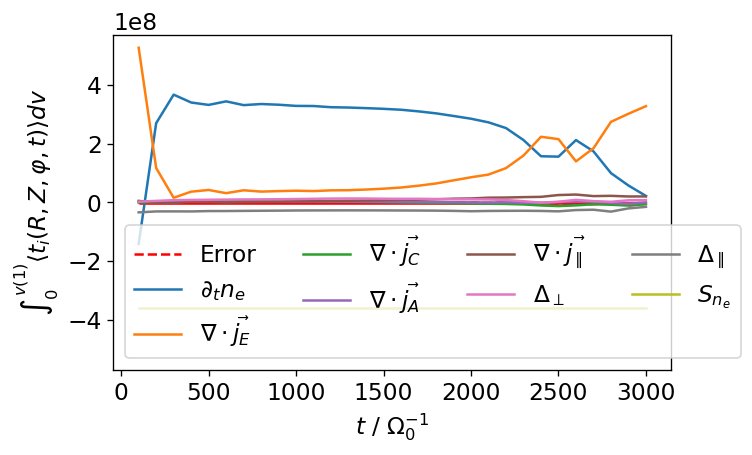

Mean error is  -1559719.7093096157  std error is  6914983.097904254


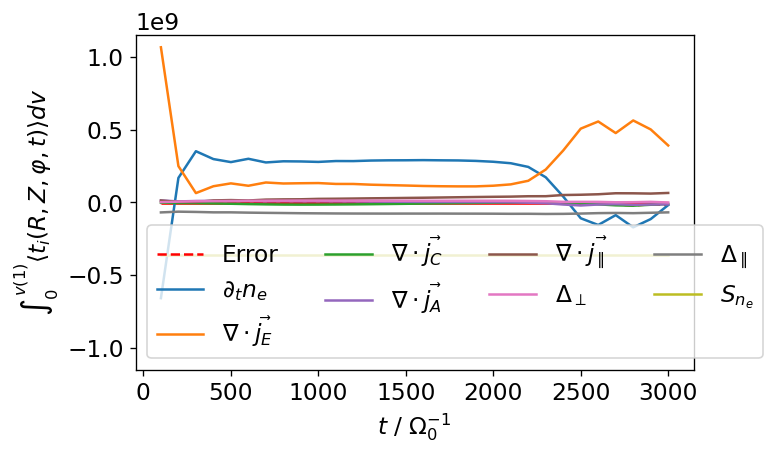

In [223]:

for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     tau = 1
    res = 1e-4
    plot_series(to_plot,ax,tau,res,start_idx=1)
    #     ax.set_yscale("linear")


    plt.legend(ncol=4,loc='lower left')
    plt.show()

tau =  0
tau =  1


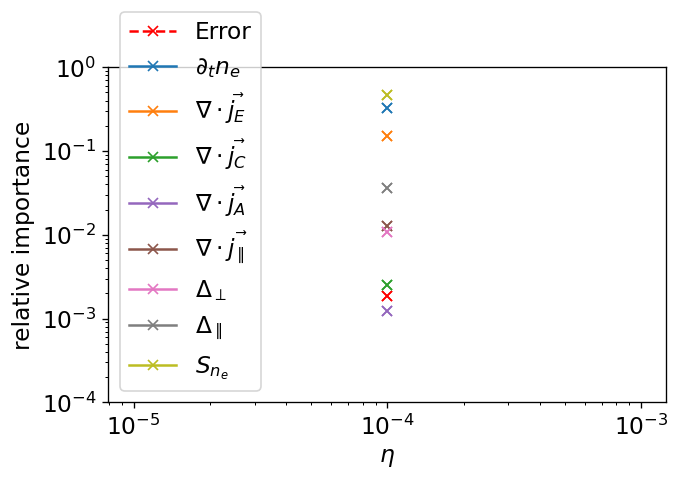

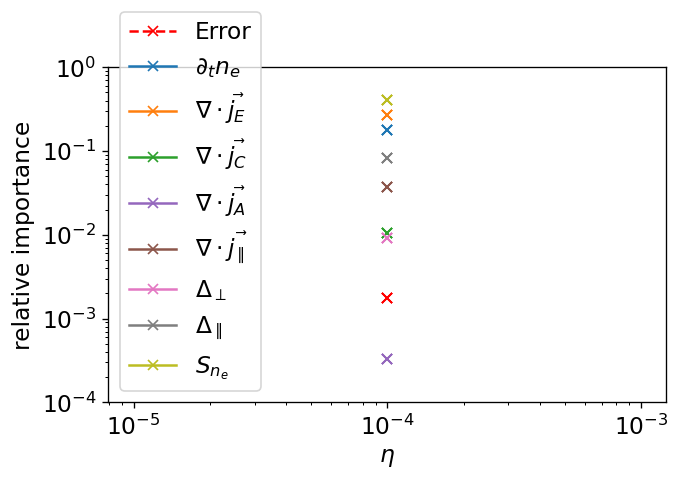

In [222]:
nn_content = [content[0],content[1]]
make_to_plot(to_plot, nn_content)
for tau in [0,1]:
    print("tau = ", tau)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 1, loc = 'lower left')
    plt.ylim([1e-4,1])
#     plt.savefig( 'ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    
nn_content = [content[1]]
make_to_plot(to_plot, nn_content)
for tau in [1]:
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot,ax,tau,'log')
#     ax.set_yscale("linear")
#     plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-4,1])
#     plt.savefig( 'ne-importance-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()

In [209]:
### THE TERMS IN THE ENERGY CONSERVATION
to_plot_energy = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["ue2_ifs_lcfs","nelnne_ifs_lcfs","nilnni_ifs_lcfs",
                   "neue2_ifs_lcfs","niui2_ifs_lcfs","aperp2_ifs_lcfs"],
        "derive" : [True], "signs" : [+1,1,1,1,1,1],
        "color": 0,
        "label" : r"$\partial_t E$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divee_tt_ifs_lcfs','divei_tt_ifs_lcfs','diveea_tt_ifs_lcfs','diveia_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1,1,1,1],
        "color": 1,
        "label" : r"$\nabla\cdot\vec{j_E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeperp_tt_ifs_lcfs','leiperp_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1,-1],
        "color": 2,
        "label" :  r"$\Delta_\perp$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['leeparallel_tt_ifs_lcfs','leiparallel_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1,-1],
        "color": 6,
        "label" :  r"$\Delta_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['see_tt_ifs_lcfs','sei_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1,-1],
        "color": 7,
        "label" :  r"$S_{E}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['resistivity_tt_ifs_lcfs'], "derive" : [False], "signs" : [-1],
        "color": 8,
        "label" :  r"$R$",
        "vals": {0:dict(),1:dict()},
    }
    ]
}



KeyError: 0.0001

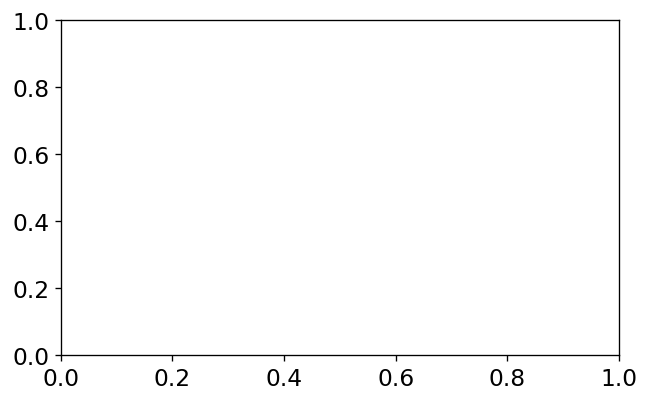

In [210]:
make_to_plot(to_plot_energy,nn_content)
# for tau in [0,1]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
plot_series(to_plot_energy,ax,tau,res,start_idx=1)

plt.legend(ncol=4,loc='lower center')
plt.show()

In [ ]:
for tau in [1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_energy,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([5e-4,1])
    plt.show()

### Vorticity accuracy on LCFS

In [204]:
### THE TERMS IN THE VORTICITY CONSERVATION
# idx=167 #=lcfs
idx = 167
to_plot_vorticity = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
#         "names" : ['oexbe_fsa'], # bad for tau = 1
        "names" : ['v_Omega_E_gf_ifs_lcfs'],
#     vorticity =np.asarray(da['oexbe_fsa'][:,:])
    # vorticity+=da['odiae_fsa'][:,:]
    # vorticity/=da['electrons_fsa'][:,:]
        "derive" : [True],"signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t (\Omega_E )$",
        "vals": {0:dict(),1:dict()},
    },
    {
#         "names" : ['jvoexbi_tt_ifs'],
        "names" : ['divoexbi_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 5,
        "label" : r"$\nabla\cdot\vec{j_\Omega,E}$",
        "vals": {0:dict(),1:dict()},
    },    
    {
#         "names" : ['jvoexbeUD_tt_ifs'], # bad for tau = 1
        "names" : ['divoexbiUD_tt_ifs_lcfs'], # also quite bad
#         "names" : ['divodiaiUE_tt_ifs_lcfs'],
#         "names" : ['jvodiaiUE_tt_ifs'], # above 10%
        "derive" : [False], "signs" : [+1],
        "color": 2,
        "label" : r"$\nabla\cdot\vec{ j_\Omega,D}$",
        "vals": {0:dict(),1:dict()},
    },  
    {
        "names" : ['divoApar_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [+1],
        "color": 8,
        "label" : r"$Maxwell$",
        "vals": {0:dict(),1:dict()},
    },
#     {
# #         "names" : ['jvoexbApar_tt_ifs'],
#         "names" : ['jvodiaApar_tt_ifs'],
#         "idx": idx,"derive" : False, "signs" : [+1],
#         "color": 9,
#         "label" : r"$\nabla\cdot\vec{ j_{\Omega,D,A}}$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['loexbe_tt_fsa'],"idx":idx, "derive" : False, "sign" : -1,
#         "color": 1,
#         "label" :  r"$\Lambda$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['divcurvne_tt_ifs_lcfs','divcurvni_tt_ifs_lcfs',
                   'divcurvkappae_tt_ifs_lcfs','divcurvkappai_tt_ifs_lcfs'],
#     # force2 = -da["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
        "derive" : [False], "signs" : [+1,+1,+1,+1],
        "color": 6,
        "label" :  r"$Force$",
        "vals": {0:dict(),1:dict()},
    }
#     {
#         "names" : [''], "derive" : False, "sign" : -1,
#     # source = da["sosne_tt_fsa"][:,:]/deltat[:,None]
#     # source+= da["sospi_tt_fsa"][:,:]/deltat[:,None]
#         "color": 7,
#         "label" :  r"$S_{E}$",
#         "vals": {0:dict(),1:dict()},
#     },
    ]
}


Mean error is  3015741.604143623  std error is  5871476.765211567


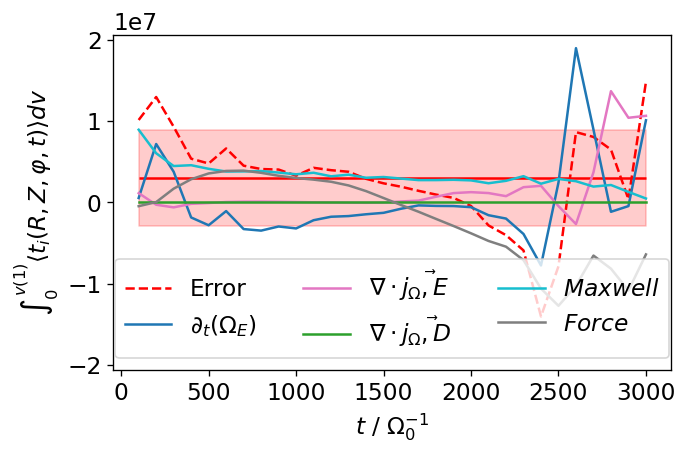

Mean error is  21971046.872967575  std error is  11150484.92465466


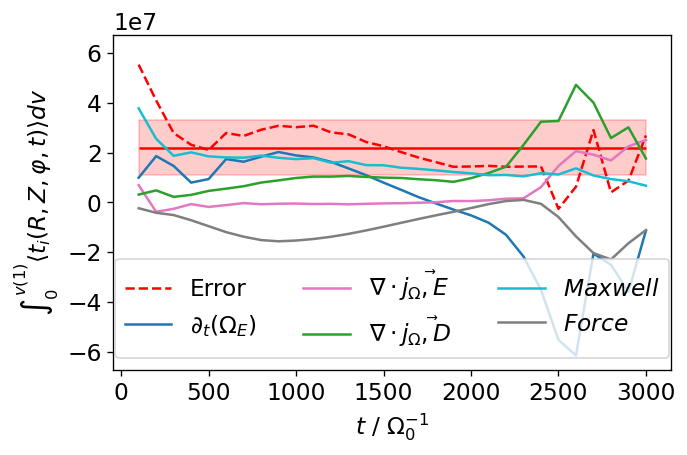

In [205]:

make_to_plot(to_plot_vorticity,[content[0],content[1]])
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    plot_series(to_plot_vorticity,ax,tau,res)

    plt.legend(ncol=3,loc='lower center')
    plt.show()

/tmp/ipykernel_8788/2126072632.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([-1,1])


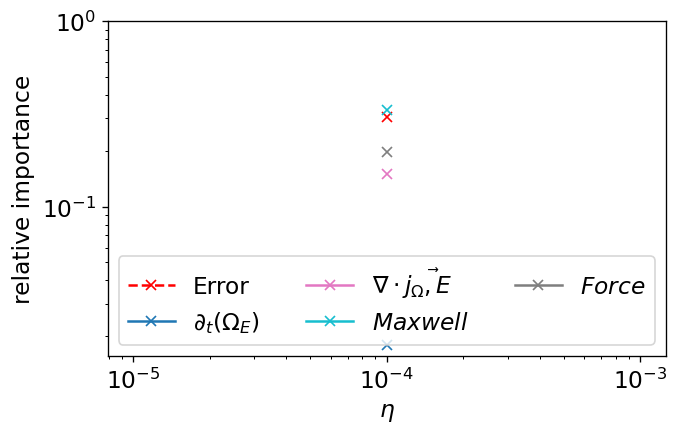

/tmp/ipykernel_8788/2126072632.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([-1,1])


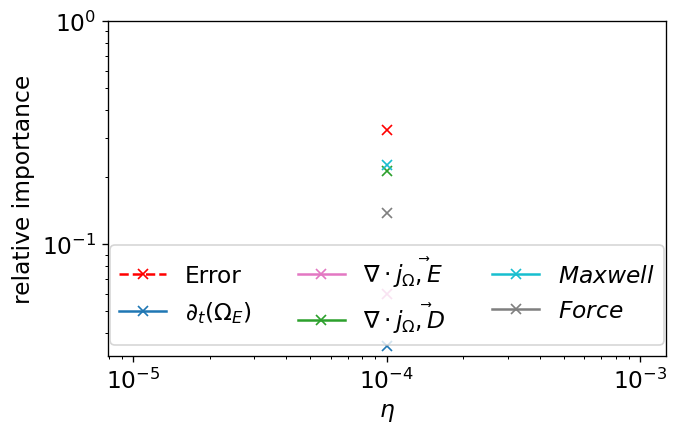

In [206]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    plot_relative(to_plot_vorticity,ax,tau,'log')
#     ax.set_yscale("linear")
#     plt.legend()
    plt.legend( ncol=3, loc='lower center'#, bbox_to_anchor=(0.5, 1.05),
         )#, fancybox=True, shadow=True)
    ax.set_ylim([-1,1])
    plt.show()

## Ion parallel momentum

In [180]:
### THE TERMS IN THE TOROIDAL MOMENTUM
to_plot_momentum = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ["niui_ifs_lcfs"], "derive" : [True], "signs" : [+1],
        "color": 0,
        "label" : r"$\partial_t N_iU_{\parallel,i}$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divparexbii_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_E})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divparApari_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 2,
        "label" : r"$\nabla\cdot(\vec{j_A})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['divpardiai_tt_ifs_lcfs','divparkappai_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 1,
        "label" : r"$\nabla\cdot(\vec{j_C})$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrori_tt_ifs_lcfs"],
        "derive" : [False], "signs" : [-1],
        "color": 5,
        "label" : r"$\nabla_\parallel(N_i)$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ["sparmirrorAi_tt_ifs_lcfs"],
        "derive" : [False], "signs" : [-1],
        "color": 6,
        "label" : r"$\nabla_{A,\parallel}(N_i)$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ["sparsni_tt_ifs_lcfs"],
#         "derive" : [False], "signs" : [1],
#         "color": 3,
#         "label" : r"$S$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparphii_tt_ifs_lcfs','sparphiAi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,-1],
        "color": 4,
        "label" : r"$N_i\nabla_\parallel\psi +  N_i\nabla_{A,\parallel}\psi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAi_tt_ifs_lcfs','friction_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [-1,+1],
        "color": 8,
        "label" : r"$N_i\partial_t A_\parallel+ R$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}



tau =  0
Mean error is  32629528.64288227  std error is  23973980.42558943


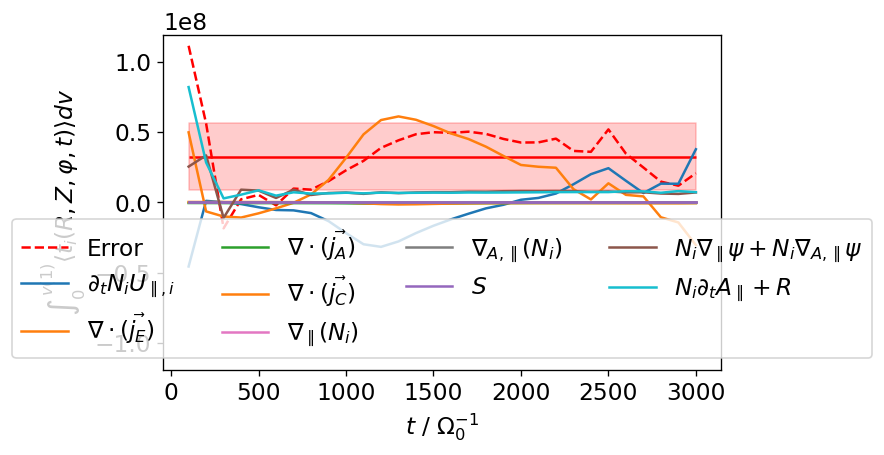

tau =  1
Mean error is  78226798.56524803  std error is  70416333.69475698


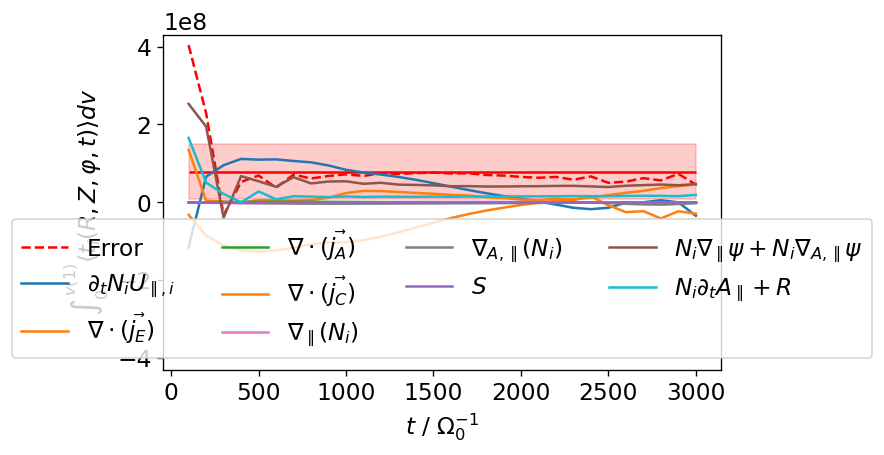

In [181]:
content_nn = [content[0],content[1]]
make_to_plot(to_plot_momentum, content_nn)
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    print("tau = ", tau)
    res = 1e-4
    plot_series(to_plot_momentum,ax,tau,res,start_idx=1)

    plt.legend(ncol = 4, loc = 'lower center')
    plt.show()

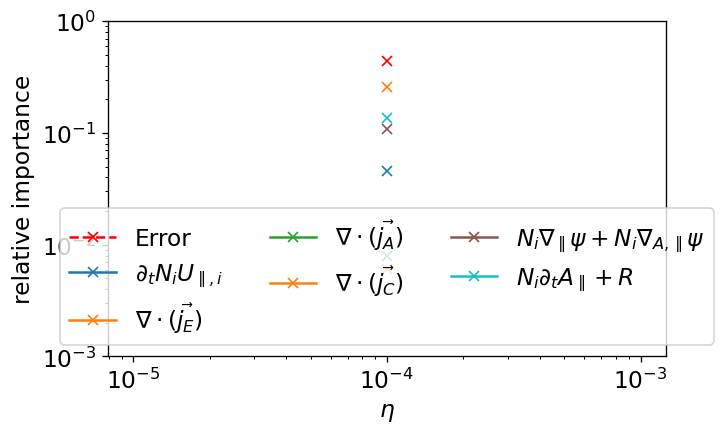

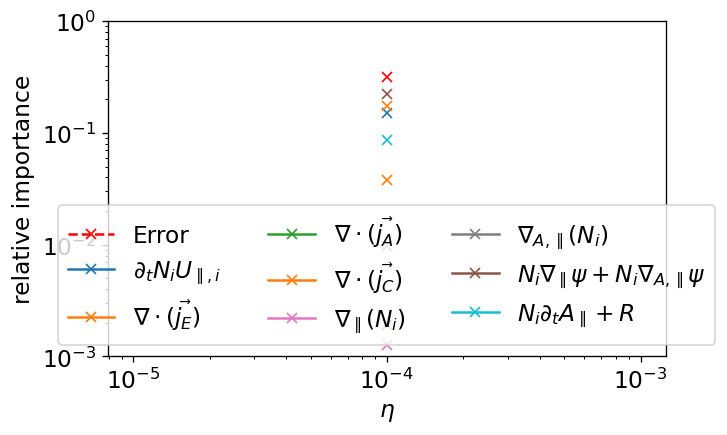

In [177]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_momentum,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol = 3, loc = 'lower center')
    plt.ylim([1e-3,1])
    plt.show()

## Parallel electron force balance

In [125]:
### THE TERMS IN THE PARALLEL ELECTRON FORCE BALANCE
to_plot_electron_force = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
    {
        "names" : ['sparmirrore_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 5,
        "label" : r"$Mirror$",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['friction_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 2,
#         "label" : r"$\eta$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparphie_tt_ifs_lcfs','friction_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 3,
        "label" : r"$n_e\nabla_\parallel\phi + R$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['sparphiAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 4,
        "label" : r"$n_e\nabla_{A,\parallel}\phi$",
        "vals": {0:dict(),1:dict()},
    },
    {
        "names" : ['spardotAe_tt_ifs_lcfs'],
        "derive" : [False], "signs" : [1],
        "color": 8,
        "label" : r"$n_e\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    { # it works better without ...
        "names" : ['sparmirrorAe_tt_ifs_lcfs'], "derive" : [False], "signs" : [+1],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}


tau =  0
Mean error is  -285921.94336503866  std error is  235730.31023830993


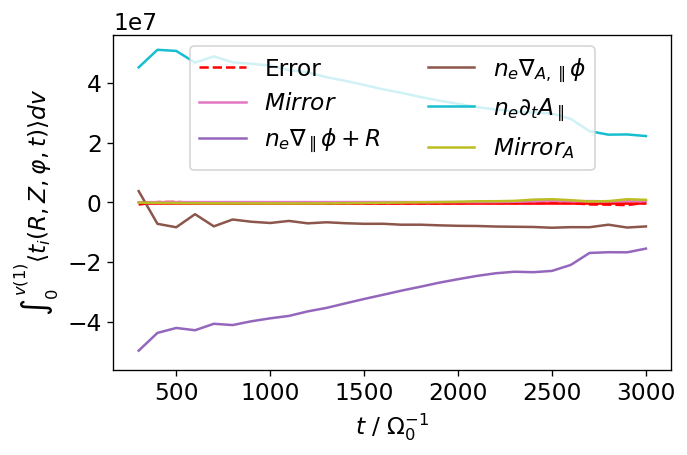

tau =  1
Mean error is  -529673.1530150325  std error is  377719.13635864476


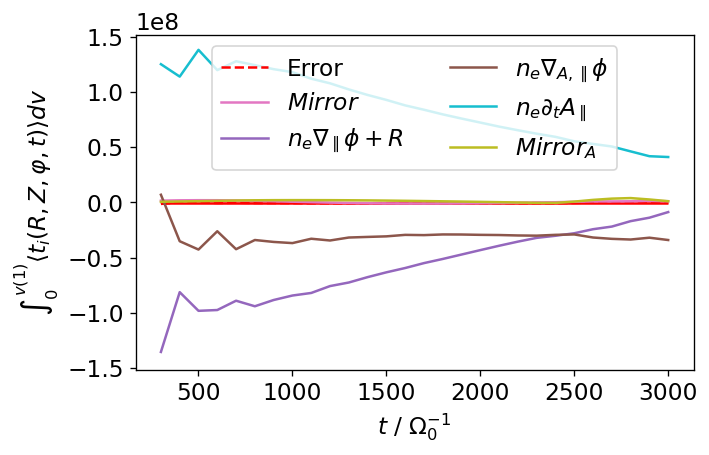

In [126]:
content_nn = [content[0],content[1]]
make_to_plot(to_plot_electron_force,content_nn)
for tau in [0,1]:
    print( "tau = ", tau)
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    res = 1e-4
    plot_series(to_plot_electron_force,ax,tau,res,start_idx=3)
    low, high = ax.get_ylim()
    bound = 4000# max(abs(low), abs(high))
    # ax.set_ylim(-bound, bound)
    # ax.set_xlim(1000,100000)
    plt.legend(ncol = 2, loc='upper center')
    plt.show()

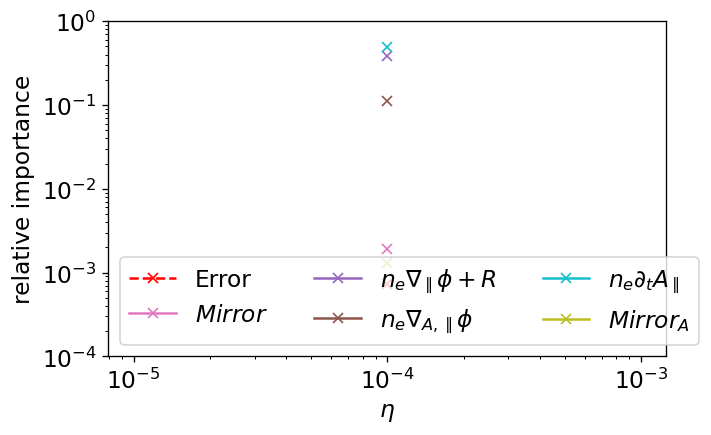

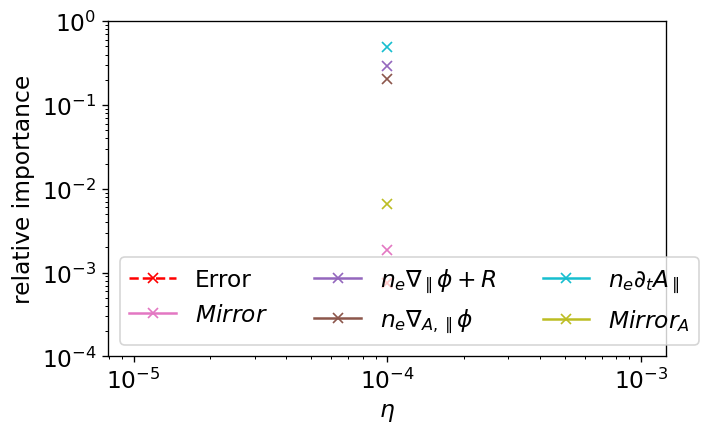

In [127]:
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    
    plot_relative(to_plot_electron_force,ax,tau,'log')
#     ax.set_yscale("linear")
    plt.legend(ncol=3, loc = 'lower left')
    plt.ylim([1e-4,1])
    plt.show()

In [129]:
### TEST if ion and electron force terms are small against the parallel pressure gradient
to_plot_electron_force_diff = {
    "tau" : [0,1], # taus
    "res": {0:[],1:[]}, # resistivities for taus
    "times": {0:dict(),1:dict()},
    "params" : {0:dict(),1:dict()}, # a copy of all parameters
    "fields" : [ # list of dicts
#     {
#         "names" : ['sparmirrore_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 5,
#         "label" : r"$Mirror$",
#         "vals": {0:dict(),1:dict()},
#     },
#     {
#         "names" : ['friction_tt_ifs_lcfs'],
#         "derive" : [False], "signs" : [1],
#         "color": 2,
#         "label" : r"$\eta$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['sparphie_tt_ifs_lcfs','sparphii_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 3,
        "label" : r"$\delta N\nabla_\parallel\phi $",
        "vals": {0:dict(),1:dict()},
    },
#     {
#         "names" : ['sparphiAe_tt_ifs_lcfs','sparphiAi_tt_ifs_lcfs'],
#         "derive" : [False,False], "signs" : [1,1],
#         "color": 4,
#         "label" : r"$\delta N \nabla_{A,\parallel}\phi$",
#         "vals": {0:dict(),1:dict()},
#     },
    {
        "names" : ['spardotAe_tt_ifs_lcfs','spardotAi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [1,1],
        "color": 8,
        "label" : r"$\delta N\partial_t A_\parallel$",
        "vals": {0:dict(),1:dict()},
    },
    { # it works better without ...
        "names" : ['sparmirrorAe_tt_ifs_lcfs','sparmirrorAi_tt_ifs_lcfs'],
        "derive" : [False,False], "signs" : [+1,+1],
        "color": 7,
        "label" : r"$Mirror_A$",
        "vals": {0:dict(),1:dict()},
    },
    ]
}


Mean error is  154812.1048740623  std error is  582186.1141626849


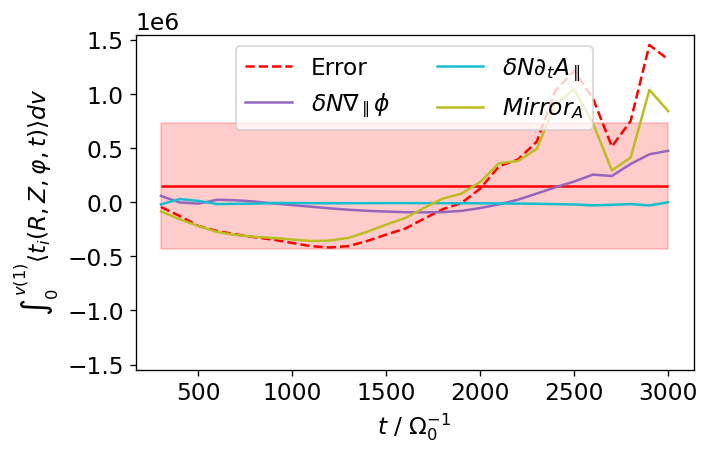

Mean error is  4504495.063400764  std error is  2080528.435325986


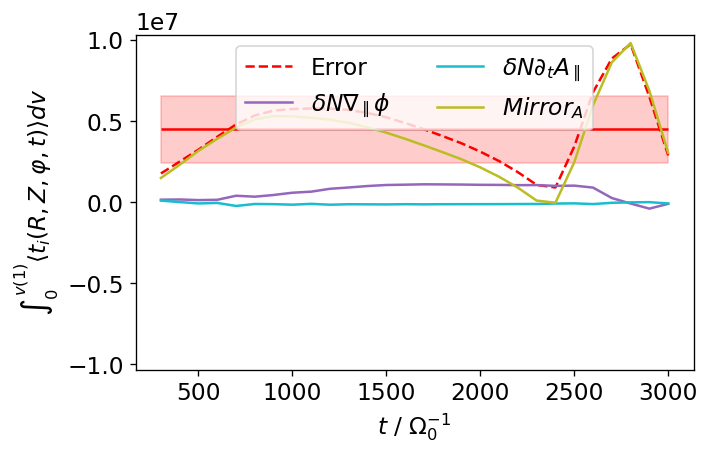

In [130]:
content_nn = [content[0],content[1]]
make_to_plot(to_plot_electron_force_diff,content_nn)
for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
#     tau = 1
    res = 1e-4
    plot_series(to_plot_electron_force_diff,ax,tau,res,start_idx=3)
    low, high = ax.get_ylim()
    bound = 4000# max(abs(low), abs(high))
    # ax.set_ylim(-bound, bound)
    # ax.set_xlim(1000,100000)
    plt.legend(ncol = 2, loc='upper center')
    plt.show()